In [1]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from dateutil import rrule
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
import numpy as np


In [2]:
#logica de programação
#definir qual é o site
# criar um dicionario data da cotação, mês de referencia para aquela data selecionada e o preço em relaçao aquela data e mês de referencia 
#definir qual são as informações que precisamos: inspecionar o site
#Criar um data frame com o dicionario
# criar um loop para buscar todas as datas e informações



In [48]:
# URL base do site
url_base = 'https://www.noticiasagricolas.com.br/cotacoes/soja/premio-soja-paranagua-pr/'

# Data de início e fim da busca
data_inicio = datetime(2019, 5, 20)
data_fim = datetime(2020, 5, 20)

# Gera uma sequência de datas diárias entre as datas de início e fim
datas = [data for data in rrule.rrule(rrule.DAILY, dtstart=data_inicio, until=data_fim) if data.weekday() < 5]

# Cria uma lista para armazenar os dataframes de cada dia
dfs = []

# Itera sobre as datas e obtém as informações para cada dia
for data in datas:
    # Converte a data para uma string no formato usado na URL
    data_str = data.strftime('%Y-%m-%d')
    
    # Monta a URL completa para o dia desejado
    url = url_base + data_str

    # Faz a requisição HTTP para obter o HTML da página
    response = requests.get(url)

    # Verifica se a requisição foi bem sucedida (código 200)
    if response.status_code == 200:
        # Faz o parsing do HTML usando o BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Encontra a data de fechamento
        elemento_fechamento = soup.find("div", {"class": "fechamento"})
        if elemento_fechamento:
            data_fechamento = elemento_fechamento.text.replace("Fechamento: ", "")
        else:
            data_fechamento = "Data de fechamento não encontrada"

        tabela_cotacoes = soup.find("table", {"class": "cot-fisicas"})

        # Verifica se a tabela foi encontrada antes de continuar
        if tabela_cotacoes:
            # Encontra todas as linhas da tabela
            linhas = tabela_cotacoes.find_all("tr")

            # Cria uma lista de dicionários com os dados
            dados = []
            for linha in linhas:
                colunas = linha.find_all("td")
                if colunas:
                    mes = colunas[0].text
                    preco = colunas[1].text
                    dados.append({'Data de fechamento': data_fechamento, 'Mês': mes, 'Preço': preco})

            # Cria o DataFrame a partir dos dados
            df = pd.DataFrame(dados)

            # Adiciona o dataframe à lista
            dfs.append(df)
        else:
            print(f'Tabela de cotações não encontrada para {data_str}')
    else:
        print(f'Falha na requisição HTTP para {url}')

# Concatena todos os dataframes em um único dataframe
df_final = pd.concat(dfs)

# Exibe o dataframe final

df_final.describe()


Tabela de cotações não encontrada para 2019-05-27
Tabela de cotações não encontrada para 2019-06-20
Tabela de cotações não encontrada para 2019-07-04
Tabela de cotações não encontrada para 2019-09-30
Tabela de cotações não encontrada para 2019-10-11
Tabela de cotações não encontrada para 2019-11-15
Tabela de cotações não encontrada para 2019-12-24
Tabela de cotações não encontrada para 2019-12-25
Tabela de cotações não encontrada para 2019-12-26
Tabela de cotações não encontrada para 2019-12-27
Tabela de cotações não encontrada para 2019-12-30
Tabela de cotações não encontrada para 2019-12-31
Tabela de cotações não encontrada para 2020-01-01
Tabela de cotações não encontrada para 2020-02-25
Tabela de cotações não encontrada para 2020-04-10
Tabela de cotações não encontrada para 2020-04-21
Tabela de cotações não encontrada para 2020-05-01


,Data de fechamento,Mês,Preço
count,983,983,983
unique,246,17,44
top,20/05/2019,Fevereiro/20,"+0,45"
freq,4,141,105


In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 3
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Data de fechamento  336 non-null    object 
 1   Mês                 336 non-null    object 
 2   Preço               336 non-null    float64
dtypes: float64(1), object(2)
memory usage: 10.5+ KB


In [53]:
#nova analise
# com os dados que foram analisados precisamos entender como estão as curvas para cada mês para cada.
# para isso precisamo tratar os dados. 1º o dtype deles esta errado, converter data para data e preço para float mantendo o numero positivo e negativo.
# criar uma coluna media movel para cada mês , criar uma média para toda a curva de um ano inteiro 

In [52]:
# Converter a coluna 'Preço' para string e substituir vírgulas por pontos
df_final['Preço'] = df_final['Preço'].astype(str).str.replace(',', '.')

# Converter a coluna 'Preço' para float e garantir que os números sejam positivos ou negativos
df_final['Preço'] = pd.to_numeric(df_final['Preço'], errors='coerce')

# Converter a coluna 'Data de fechamento' para datetime
df_final['Data de fechamento'] = pd.to_datetime(df_final['Data de fechamento'], format='%d/%m/%Y %H:%M:%S')

# Extrair apenas a data da coluna 'Data de fechamento'
df_final['Data de fechamento'] = df_final['Data de fechamento'].dt.date

# Salvar o DataFrame em um arquivo Excel
df_final.to_excel('correto premio.xlsx', index=False)

# Exibir o DataFrame
print(df_final)

ValueError: time data '20/05/2019' does not match format '%d/%m/%Y %H:%M:%S' (match)

In [53]:
# Criar novo DataFrame com informações organizadas para gráficos
df_graficos = df_final.pivot_table(values='Preço', index='Data de fechamento', columns='Mês')

# Exibir novo DataFrame
display(df_graficos)

Mês,Abril/20,Agosto/19,Agosto/20,Dezembro/19,Fevereiro/20,Janeiro/20,Julho/19,Julho/20,Junho/19,Junho/20,Maio/19,Maio/20,Março/20,Novembro/19,Novembro/20,Outubro/19,Setembro/19
Data de fechamento,,,,,,,,,,,,,,,,,
01/04/2020,0.45,NaN,NaN,NaN,NaN,NaN,NaN,0.48,NaN,0.5,NaN,0.4,NaN,NaN,NaN,NaN,NaN
01/07/2019,NaN,1.05,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,1.08
01/08/2019,NaN,0.90,NaN,NaN,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95,0.95
01/10/2019,NaN,NaN,NaN,NaN,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,0.80,0.75,NaN
01/11/2019,NaN,NaN,NaN,NaN,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,0.85,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/01/2020,0.35,NaN,NaN,NaN,0.45,0.55,NaN,NaN,NaN,NaN,NaN,NaN,0.45,NaN,NaN,NaN,NaN
31/03/2020,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,0.4,0.50,NaN,NaN,NaN,NaN
31/05/2019,NaN,1.15,NaN,NaN,NaN,NaN,1.16,NaN,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15


In [54]:
# Criar novo DataFrame com informações organizadas para gráficos
df_graficos = df_final.pivot_table(values='Preço', index='Data de fechamento', columns='Mês')

# Criar coluna com a média móvel dos últimos 3 dias para cada mês
df_graficos_ma = df_graficos.rolling(window=3).mean()

# Exibir novo DataFrame com a média móvel
display(df_graficos_ma)

Mês,Abril/20,Agosto/19,Agosto/20,Dezembro/19,Fevereiro/20,Janeiro/20,Julho/19,Julho/20,Junho/19,Junho/20,Maio/19,Maio/20,Março/20,Novembro/19,Novembro/20,Outubro/19,Setembro/19
Data de fechamento,,,,,,,,,,,,,,,,,
01/04/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01/07/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01/08/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01/10/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916667,NaN
01/11/2019,NaN,NaN,NaN,NaN,0.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/01/2020,NaN,NaN,NaN,NaN,0.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31/03/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN
31/05/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df_final['Data de fechamento'] = pd.to_datetime(df_final['Data de fechamento'], format='%d/%m/%Y')

# Criar novo DataFrame com informações organizadas para gráficos
df_graficos = df_final.pivot_table(values='Preço', index='Data de fechamento', columns='Mês')

# Criar coluna com a média móvel dos últimos 3 dias para cada mês
df_graficos_ma = df_graficos.rolling(window=3).mean()

# Criar coluna com o preço médio para cada linha
df_graficos_ma['Preço Médio'] = df_graficos_ma.agg('mean', axis=1)

# Criar coluna com o preço máximo para cada linha
df_graficos_ma['Preço Máximo'] = df_graficos_ma.agg('max', axis=1)

# Criar coluna com o preço mínimo para cada linha
df_graficos_ma['Preço Mínimo'] = df_graficos_ma.agg('min', axis=1)

# Elimando todas as linhas que estão com NaN
df_graficos_ma.dropna(how='all', inplace=True)

df_graficos_ma.sort_index(ascending=True, inplace=True)

display(df_graficos_ma)

Mês,Abril/20,Agosto/19,Agosto/20,Dezembro/19,Fevereiro/20,Janeiro/20,Julho/19,Julho/20,Junho/19,Junho/20,Maio/19,Maio/20,Março/20,Novembro/19,Novembro/20,Outubro/19,Setembro/19,Preço Médio,Preço Máximo,Preço Mínimo
Data de fechamento,,,,,,,,,,,,,,,,,,,,
2019-05-22,NaN,1.00,NaN,NaN,NaN,NaN,1.000000,NaN,0.933333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.977778,1.000000,0.933333
2019-05-23,NaN,1.00,NaN,NaN,NaN,NaN,1.000000,NaN,0.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972222,1.000000,0.916667
2019-05-24,NaN,1.05,NaN,NaN,NaN,NaN,1.053333,NaN,0.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,1.025833,1.053333,0.950000
2019-05-28,NaN,1.10,NaN,NaN,NaN,NaN,1.106667,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.10,1.076667,1.106667,1.000000
2019-05-29,NaN,1.15,NaN,NaN,NaN,NaN,1.160000,NaN,1.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15,1.127500,1.160000,1.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-14,NaN,NaN,0.85,NaN,NaN,NaN,NaN,0.78,NaN,0.68,NaN,0.580000,NaN,NaN,NaN,NaN,NaN,0.722500,0.850000,0.580000
2020-05-15,NaN,NaN,0.85,NaN,NaN,NaN,NaN,0.78,NaN,0.68,NaN,0.580000,NaN,NaN,NaN,NaN,NaN,0.722500,0.850000,0.580000
2020-05-18,NaN,NaN,0.85,NaN,NaN,NaN,NaN,0.78,NaN,0.68,NaN,0.580000,NaN,NaN,NaN,NaN,NaN,0.722500,0.850000,0.580000


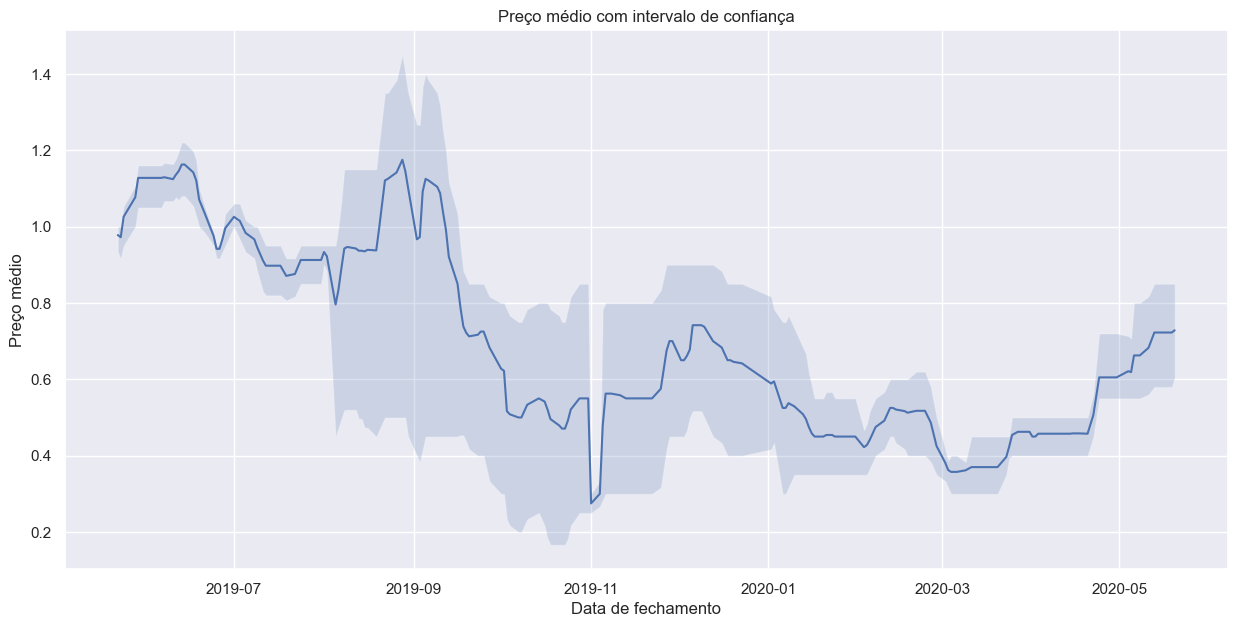

In [56]:
# Crie um objeto figura e eixos
fig, ax = plt.subplots(figsize=(15, 7))

# Crie o gráfico com o Seaborn
sns.lineplot(data=df_graficos_ma, x=df_graficos_ma.index, y='Preço Médio', ax=ax)

# Preencha a área entre a linha média e os preços máximo e mínimo
ax.fill_between(df_graficos_ma.index, df_graficos_ma['Preço Máximo'], df_graficos_ma['Preço Mínimo'], alpha=0.2)

# Adicione os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Data de fechamento')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio com intervalo de confiança')

# Exiba o gráfico
plt.show()